In [2]:
import pandas as pd
from collections import Counter
# import geopandas as gpd
import numpy as np

# Add aggregated demographic data to the shapefile of wards

In [3]:
SURVEY_LOCATION='../../Data/Bản sao của data HIDS.xlsx'

In [4]:
xls = pd.ExcelFile(SURVEY_LOCATION)

In [10]:
householders=pd.read_excel(xls, sheet_name='Form_01(Householdhead)', header=3)
all_members=pd.read_excel(xls, sheet_name='Form_02（ALLmember）', header=3)
range_hh=pd.read_excel(xls, sheet_name='Range(HouseholdHead)')
range_member=pd.read_excel(xls, sheet_name='Range(AllMember)')

Drop the first row under the header row

In [6]:
householders=householders.drop(0, axis=0)
all_members=all_members.drop(0, axis=0)

In [8]:
for q in range_hh['Question']:
    print(q)

Q1.Serial number
Q1.Name of surveyor
Q1.Neme of supervisor
Q1.Name of team leader
Q1.Name of Encoder
Q1.Date of survey
Q1.Date of survey
Q1.Date of trip surveyed
Q1.Date of trip surveyed
Q2.Have you ever participated household interview survey in 2002?
Q3.Name of house hold  head
Q4.house address
Q5.Can you or anybody currently present answer questions about the trips made by members of this household one (or two days ago)?
Q6.have telephone
Q6.telephone number
Q7.legitimacy of location of house
Q8.housing condition a. Ownership
Q8.housing condition b.floor area(m2)
Q8.housing condition c.Structure
Q8.housing condition d.Maintenance
Q8.housing condition e.Land use
Q9.if rented, how much
Q10.years stayed in present dwelling
Q11.address dwelling before
Q12.what kind of media  a. Newspaper
Q12.what kind of media b.TV
Q12.what kind of media c.Internet 
Q12.what kind of media d.Radio 
Q12.what kind of media  e.Community e.announcement
Q12.what kind of media f.Magagine
Q13.household member =

In [9]:
for q in range_member['Question']:
    print(q)

S/N
Q20a.Name
Q20b.member code
Q21.Personal data:age
Q21.Personal data:gender
Q22.Educational Attainment
Q23.Car and motorcycle driver's license
Q24.Do you personally have your own vehicles?
a.car
Q24.Do you personally have your own vehicles?
b.motorcycle
Q24.Do you personally have your own vehicles?
c.bicycle
Q24.Do you personally have your own vehicles?
d.Electric bicycle
Q25.If no, how do you manage to travel
Q26.Physical/mental challenged to travel
Q27.Residency Status a.Household head
Q27.Residency Status b.Registration status
Q27.Residency Status c.Employee of household
Q28.Occupation
Q29.If Q29 is 1-10(i.e.working), Field of Employment
Q30.If Q29 is 1-10(i.e.working), Type of company or employer?
Q31.If Q29 is 1-10(i.e.working), Employment status?
Q32.If earning, average monthly personal income(VND)
Q33.If Q29 is 1-12(i.e.working or studying), Work or School address?
Q34.If Q29 is 1-12(i.e.working/studying), Typical? FROM
Q34.If Q29 is 1-12(i.e.working/studying), Typical? FROM
Q

In [32]:
householders.groupby('Q1.Số Sêri').size()

Q1.Số Sêri
1        1
2        1
3        1
4        1
5        1
        ..
26949    1
26950    1
27563    1
27877    1
Mã số    1
Length: 20001, dtype: int64

In [33]:
all_members.groupby('Số \nSêri').size()

Số \nSêri
1.0        2
2.0        3
3.0        3
4.0        3
5.0        2
          ..
26948.0    2
26949.0    1
26950.0    4
27563.0    2
27877.0    4
Length: 20000, dtype: int64

'Q1.Số Sêri' in the household file and 'Số \nSêri' in the members file seem to indicate a serial number for households.

In [34]:
rename_cols_hh={'Q14.Tổng thu nhập hàng tháng của hộ gia đình là bao nhiêu (VNĐ/tháng)?': 'hh_income',
                'Q4.Địa chỉ nhà': 'home_address',
               'Q1.Số Sêri': 'serial_num'}
rename_cols_all={'Q29.Chỉ những người thuộc từ mục 1-10 của câu 28 mới trả lời, Lĩnh vực nghê nghiệp': 'career',
                 'Q33.Chỉ những người thuộc từ mục 1-12 của Q28 (nghĩa là đang đi học hoặc đi làm) thì mới trả lời, Địa chỉ nơi làm việc/ trường học?': 'work_school_address',
               'Số \nSêri': 'serial_num'}

In [35]:
householders=householders.rename(columns=rename_cols_hh)
all_members=all_members.rename(columns=rename_cols_all)

In [ ]:
# income_group_totals=Counter(householders['hh_income'])
# income_group_totals_ordered=[income_group_totals[float(i)] for i in range(1, 16)]
# np.cumsum(income_group_totals_ordered)

### Join some household data to the all members sheets

In [37]:
all_members=all_members.merge(householders[['home_address', 'hh_income', 'serial_num']], 
                             left_on='serial_num', right_on='serial_num')

### Map the income and career field categories to simpler CS categories 

Income groups 1 to 8 are roughly the bottom quartile <br>
Income groups 9 and 10 are 2nd and 3rd quartiles. <br>
Income groups 11 to 15 are the top quartile <br>

In [58]:
def get_simple_income_quantiles(row):
    if row['hh_income']<9:
        return '1'
    elif row['hh_income']==9:
        return '2'
    elif row['hh_income']==10:
        return '3'
    else:
        return '4'

In [62]:
all_members['hh_income']=all_members.apply(lambda row: get_simple_income_quantiles(row), axis=1)


In [63]:
all_members.groupby('hh_income').size()/len(all_members)

hh_income
1    0.262572
2    0.200806
3    0.273125
4    0.263497
dtype: float64

#### Map to NAICS codes: https://www.naics.com/search/
- TODO: revisit these with more precision. eg. career 6 seems to include retail as well as accommodation/food. career 10 should be a mix of multiple categories.'

In [77]:
field_to_naics={1: '11',
                2: '21',
                3: '23',
                4: '72',
                5: '92',
                6: '48-49',
                7: '52',
                8: '61',
                9: '62',
                10: '81'
               }

In [78]:
all_members['naics']=all_members.apply(lambda row: field_to_naics[int(row['career'])] if row['career']==row['career'] else None, axis=1)

### Create dummys for the income and field columns

In [84]:
income_dummys=pd.get_dummies(all_members['hh_income'], prefix='res_income')
career_dummys=pd.get_dummies(all_members['naics'], prefix='emp_naics')

In [87]:
for col in career_dummys.columns:
    all_members[col]=career_dummys[col]

In [86]:
for col in income_dummys.columns:
    all_members[col]=income_dummys[col]

In [ ]:
simpop_df=all_members[['naics', 'hh_income', 'home_address', 'work_school_address']].rename(columns={'home_address': 'home_geoid',
                            'work_school_address': 'work_geoid',
                            'hh_income': 'earnings'})

### Convert the Ward codes to be consistent with the shapefile using the mapping

In [4]:
code_mapping_df=pd.read_csv('../Data/GIS/Survey/ward_code_mapping.csv')

In [5]:
code_mapping_df.groupby('Com_ID').size().sort_values(ascending=False)

Com_ID
26740    3
27139    2
27427    2
27433    2
26758    2
        ..
27031    1
27037    1
27043    1
27049    1
28168    1
Length: 243, dtype: int64

Some survey codes map to the same ward code

In [6]:
code_mapping={row['Code_Zone']: row['Com_ID'] for ind, row in code_mapping_df.iterrows()}

In [35]:
for col in ['home_geoid', 'work_geoid']:
    simpop_df[col]=simpop_df.apply(lambda row: code_mapping[row[col]] if row[col] in code_mapping else None, axis=1)

In [37]:
simpop_df.dropna().to_csv('../outputs/simpop.csv', index=False)

## Perform Aggregations

In [88]:
by_home_area_income=all_members.groupby('home_address')[income_dummys.columns].sum()

In [89]:
by_home_area_income

,res_income_1,res_income_2,res_income_3,res_income_4
home_address,,,,
1,56.0,44.0,52.0,52.0
2,6.0,17.0,45.0,76.0
3,7.0,7.0,8.0,9.0
4,7.0,6.0,7.0,10.0
5,7.0,2.0,0.0,28.0
...,...,...,...,...
258,165.0,86.0,131.0,57.0
263,52.0,43.0,52.0,133.0
264,174.0,133.0,128.0,53.0


In [90]:
by_work_area_field=all_members.groupby('work_school_address')[career_dummys.columns].sum()

In [91]:
by_work_area_field

,emp_naics_11,emp_naics_21,emp_naics_23,emp_naics_48-49,emp_naics_52,emp_naics_61,emp_naics_62,emp_naics_72,emp_naics_81,emp_naics_92
work_school_address,,,,,,,,,,
1.0,5.0,10.0,12.0,12.0,16.0,12.0,9.0,19.0,55.0,5.0
2.0,2.0,23.0,16.0,20.0,35.0,10.0,15.0,56.0,65.0,11.0
3.0,1.0,11.0,20.0,43.0,34.0,8.0,19.0,46.0,99.0,15.0
4.0,2.0,17.0,5.0,25.0,22.0,3.0,12.0,47.0,58.0,7.0
5.0,0.0,12.0,9.0,17.0,19.0,2.0,9.0,28.0,62.0,6.0
...,...,...,...,...,...,...,...,...,...,...
292.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
293.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


### Scale up survey data to actual population

In [92]:
by_home_area_income*=100
by_work_area_field*=100

### Calculate Totals

In [93]:
by_home_area_income['res_total']=by_home_area_income.sum(axis=1)
by_work_area_field['emp_total']=by_work_area_field.sum(axis=1)

In [94]:
by_home_area_income.to_csv('../outputs/by_home_area_income.csv')
by_work_area_field.to_csv('../outputs/by_work_area_field.csv')

## Join attributes to shape file

In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
by_home_area_income=pd.read_csv('../outputs/by_home_area_income.csv', index_col=0)
by_work_area_field=pd.read_csv('../outputs/by_work_area_field.csv', index_col=0)

In [3]:
population=gpd.read_file('../Data/GIS/Population/population_HCMC/population_shapefile/Population_Ward_Level.shp')

In [7]:
by_home_area_income['GEOID']=[str(code_mapping[i]) if i in code_mapping else -1 for i in by_home_area_income.index]
by_work_area_field['GEOID']=[str(code_mapping[i]) if i in code_mapping else -1 for i in by_work_area_field.index]

Aggregate the ones with the same ward code

In [8]:
by_home_geoid_income=by_home_area_income.groupby('GEOID').sum()
by_work_geoid_field=by_work_area_field.groupby('GEOID').sum()

In [9]:
by_home_geoid_income=by_home_geoid_income.drop(-1)
by_work_geoid_field=by_work_geoid_field.drop(-1)

In [10]:
by_home_geoid_income

,res_income_1,res_income_2,res_income_3,res_income_4,res_total
GEOID,,,,,
25741,12700.0,5500.0,7300.0,4200.0,29700.0
25744,22900.0,10700.0,15200.0,10500.0,59300.0
25759,3100.0,4300.0,3500.0,2800.0,13700.0
25765,14300.0,5100.0,6500.0,3500.0,29400.0
25942,36400.0,33300.0,32300.0,14600.0,116600.0
...,...,...,...,...,...
28027,10800.0,3000.0,400.0,700.0,14900.0
28111,24800.0,8900.0,9400.0,2400.0,45500.0
28159,14000.0,7300.0,8600.0,4600.0,34500.0


In [11]:
by_home_geoid_income.sum()

res_income_1    1589900.0
res_income_2    1215700.0
res_income_3    1653800.0
res_income_4    1595500.0
res_total       6054900.0
dtype: float64

In [12]:
population['GEOID']=population['Com_ID'].astype(str)

In [13]:
population=population.set_index('GEOID')

In [14]:
zones=population.merge(by_home_geoid_income, left_index=True, right_index=True, how='left')

In [15]:
zones=zones.merge(by_work_geoid_field, left_index=True, right_index=True, how='left')

In [16]:
centroids=zones['geometry'].centroid
zones['x_centroid']=[c.x for c in centroids]
zones['y_centroid']=[c.y for c in centroids]

In [17]:
zones['sim_area']=zones['Dist_Name']=='District 4'
zones['model_area']=True
zones['reference_area']=zones['Dist_Name']=='District 4'

In [18]:
zones=zones.rename(columns={'Shape_Area': 'area'})

In [19]:
zones=zones.to_crs('EPSG:4326')

<AxesSubplot:>

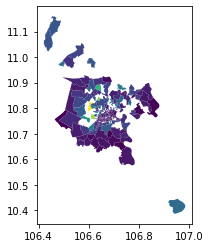

In [20]:
zones.plot(column='res_total')

<AxesSubplot:>

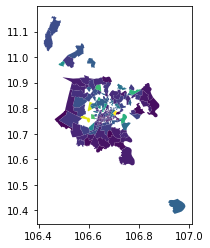

In [21]:
zones.plot(column='emp_total')

### TODO: estimate the attributes of the areas with no data

In [22]:
zones.to_file('../outputs/zones.geojson', driver='GeoJSON')

# Create the simulated population file

In [23]:
# od=gpd.read_file('../Data/GIS/OD_2014/OD_Shapefile/2014_HIDS_OD_Matrix.shp')

In [24]:
# income_cols=[col for col in zones.columns if 'res_income' in col]
# naics_cols=[col for col in zones.columns if 'emp_naics' in col]

In [25]:
# row['NumberFlow']

In [26]:
# import numpy as np
# simpop=[]
# for ind, row in od.iterrows():
#     if ((str(row['Start_Code']) in zones.index) and (str(row['End_Code']) in zones.index)):
#         sampled_income_cols=np.random.choice(income_cols, row['NumberFlow'],
#             p=[zones.loc[str(row['Start_Code']), col]/zones.loc[str(row['Start_Code']), 'res_total'] for col in income_cols])

#         sampled_naics_cols=np.random.choice(naics_cols, row['NumberFlow'],
#             p=[zones.loc[str(row['End_Code']), col]/zones.loc[str(row['End_Code']), 'emp_total'] for col in naics_cols])

#         for i in range(row['NumberFlow']):
#             income=sampled_income_cols[i].split('res_income_')[1]

#             naics=sampled_naics_cols[i].split('emp_naics_')[1]

#             simpop.append({'home_geoid': str(row['Start_Code']),
#                           'work_geoid': str(row['End_Code']),
#                           'earnings': income,
#                           'naics': naics})
# simpop_df=pd.DataFrame(simpop)
# simpop_df

In [27]:
# simpop_df.to_csv('../outputs/simpop.csv', index=False)